In [3]:
# Install uv, a fast package installer that works as a drop-in replacement for pip
%pip install uv

# Install required packages using uv
# Note: %uv is a line magic specific to uv in Jupyter. If that fails, fall back to regular %pip.

# chromadb: lightweight vector DB for storing embeddings
!uv pip install chromadb==0.4.22

# tiktoken: tokenizer used by OpenAI models
!uv pip install tiktoken==0.9.0

# Core LangChain framework
!uv pip install langchain==0.3.20

# LangChain community integrations
!uv pip install langchain-community==0.3.10

# OpenAI integration for LangChain
!uv pip install langchain-openai==0.3.1

# LangChain Hub for prebuilt chains/tools
!uv pip install langchainhub

# Text splitters for chunking long documents
!uv pip install langchain-text-splitters==0.3.6

# LangGraph: for graph-based AI workflows
!uv pip install langgraph==0.3.1

# OpenAI SDK
!uv pip install openai==1.65.3

# PDF parsing tools (optional but useful)
!uv pip install PyMuPDF==1.25.3
!uv pip install pypdf==5.3.1

# Image processing and HTML parsing libraries
!uv pip install pillow==11.1.0
!uv pip install beautifulsoup4==4.13.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 5.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
Using Python 3.12.2 environment at: /opt/anaconda3
Resolved 81 packages in 1.44s                                        
Prepared 3 packages in 7.05s                                             
Uninstalled 2 packages in 24ms
Installed 3 packages in 1ms                                 
 - chroma-hnswlib==0.7.6
 + chroma-hnswlib==0.7.3
 - chromadb==0.6.3
 + chromadb==0.4.22
 + pulsar-client==3.6.1
Using Python 3.12.2 environment at: /opt/anaconda3
Audited 1 package in 9ms
Using Python 3.12.2 environment at: /opt/anaconda3
Resolved 26 packages in 657ms                                        
Prepared 1 package in 293ms                                              
Uninstalled 1 package in 131ms
Installed 1 package in 8ms                                  
 - langchain==0.3.13
 + langchain==0.3.20
Using Python 3.12.2 environment at: /opt/a

In [3]:
# Import required libraries
import getpass  # Used to securely prompt for sensitive input (e.g., API keys)
import os       # Used to access and set environment variables

# Define a helper function to set an environment variable if it's not already set
def _set_env(key: str):
    # Check if the environment variable is already defined
    if key not in os.environ:
        # Prompt the user to enter the value securely (input is hidden)
        os.environ[key] = getpass.getpass(f"{key}:")  

# Call the function to set the OpenAI API key
# This will prompt the user to enter their OpenAI API key, and store it securely
_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ········


In [7]:
# Import necessary components for loading, splitting, embedding, and storing documents
from langchain_community.document_loaders import WebBaseLoader  # For scraping web pages
from langchain_community.vectorstores import Chroma             # Vector store for semantic search
from langchain_openai import OpenAIEmbeddings                   # OpenAI embeddings for document vectorization
from langchain_text_splitters import RecursiveCharacterTextSplitter  # For splitting large text into chunks

# List of Dell laptop product URLs to scrape
urls = [    
    "https://www.dell.com/en-us/shop/dell-laptops/inspiron-14-2-in-1-laptop/spd/inspiron-14-7440-2-in-1-laptop",
    "https://www.dell.com/en-us/shop/dell-laptops/latitude-5450-laptop/spd/latitude-14-5450-laptop",
    "https://www.dell.com/en-us/shop/dell-laptops/latitude-7450-laptop/spd/latitude-14-7450-2-in-1-laptop",
    "https://www.dell.com/en-us/shop/dell-laptops/xps-14-laptop/spd/xps-14-9440-laptop",
]

# Load and scrape the HTML content from each URL using WebBaseLoader
# Each call returns a list of Document objects, so we flatten them later
docs = [WebBaseLoader(url).load() for url in urls]

# Flatten the list of lists into a single list of documents
docs_list = [item for sublist in docs for item in sublist]

# Use RecursiveCharacterTextSplitter to break documents into overlapping chunks
# This improves embedding performance and search accuracy
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=3000,      # Max number of characters in each chunk
    chunk_overlap=50      # Overlap between chunks for context retention
)
doc_splits = text_splitter.split_documents(docs_list)

# Convert text chunks into vector embeddings and store in ChromaDB
# OpenAIEmbeddings is used to create numerical representations of text
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",       # Name of the collection in Chroma
    embedding=OpenAIEmbeddings(),       # Embedding model
)

# Create a retriever interface from the vectorstore
# This allows us to perform similarity search over embedded chunks
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [9]:
# Print the full list of loaded Document objects (from all Dell URLs)
# Note: This may produce a large amount of output, as each document contains a lot of page content
print(docs_list)

[Document(metadata={'source': 'https://www.dell.com/en-us/shop/dell-laptops/inspiron-14-2-in-1-laptop/spd/inspiron-14-7440-2-in-1-laptop', 'title': 'Dell Inspiron 14 2 in 1 Laptop 7440 with Intel processor | Dell USA', 'language': 'en-US'}, page_content='Dell Inspiron 14 2 in 1 Laptop 7440 with Intel processor | Dell USAdds__loading-sqrsdds__homechevron-leftdds__icon--chevron-leftchevron-rightdds__stardds__boltalert-info-circhevron-upchevron-downalert-check-cirdds__paint-palettedds__power-supplydds__icon--arrow-rightdds__icon--card-creditdds__icon--tag-dealdds__icon--shippingdds__icon--cubedds__icon--add-cirupd-left-arrowdds__icon--gear-wrench\n\nSkip to main content              Sign In    WelcomeDell SitesDell TechnologiesPremier Sign InPartner Program Sign InDell Financial ServicesSupportDell SitesDell TechnologiesPremier Sign InPartner Program Sign InDell Financial ServicesSupportMy AccountOrder StatusProfile SettingsMy ProductsMake a PaymentDell Rewards Balance Sign Out Welcome to

In [11]:
# Import the helper function to create a retriever-based tool
from langchain.tools.retriever import create_retriever_tool

# Create a retriever tool from the previously defined vectorstore retriever
# This tool enables the agent to search for relevant laptop product info
retriever_tool = create_retriever_tool(
    retriever,                         # The retriever object created from Chroma
    "retrieve_products",              # The name of the tool (used internally by the agent)
    "Search and return information about a product for customer to purchase",  # Description of the tool's purpose
)

# Store the tool in a list for future use by the LangGraph agent
tools = [retriever_tool]

In [13]:
# Import types needed to define the agent's internal state
from typing import Annotated, Sequence                # For typing lists with additional behavior
from typing_extensions import TypedDict              # For defining structured state objects

from langchain_core.messages import BaseMessage      # Base class for all messages (user, AI, system)

from langgraph.graph.message import add_messages     # A reducer function that appends new messages to state


# Define the internal state of the agent using a TypedDict
class AgentState(TypedDict):
    # 'messages' stores the conversation history
    # Annotated[Sequence[BaseMessage], add_messages] tells LangGraph to append new messages to the list
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [78]:
# Import typing tools to define state structure and flow routing
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

# Import base message classes and prompt tools
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

# For validating structured outputs from models
from pydantic import BaseModel, Field

# Replacement for the broken import: tools_condition
# This function will check if the agent invoked a tool
def route_based_on_tool(state) -> str:
    """
    Custom router: if the last agent message includes a tool call, route to 'retrieve', otherwise to END.
    """
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    return END

### --- Edges: Logic to determine the next step in the graph ---

def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the user's question.

    Returns:
        "generate" if relevant, "rewrite" if not.
    """
    print("---CHECK RELEVANCE---")

    # Define a simple structured output schema for binary relevance scoring
    class grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # Use a small GPT-4o model to reduce cost and increase speed
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)

    # Wrap model to produce structured output based on the `grade` schema
    llm_with_tool = model.with_structured_output(grade)

    # Prompt to instruct the model how to judge relevance
    prompt = PromptTemplate(
        template="""You are a salesperson customizing the design of a Dell computer to recommend to the customer. \n
        The customer wants to know the model name, CPU, memory, storage, and price in dollars. \n\n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains all keywords and semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no'.""",
        input_variables=["context", "question"],
    )

    # Combine prompt with model and tool
    chain = prompt | llm_with_tool

    # Extract messages from state
    messages = state["messages"]
    last_message = messages[-1]         # Contains retrieved docs
    question = messages[0].content      # The original user input
    docs = last_message.content

    # Run the grading chain
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

### --- Nodes: Individual tasks in the LangGraph ---

def agent(state):
    """
    Calls the agent model to interpret the question and possibly invoke tools.
    """
    print("---CALL AGENT---")
    messages = state["messages"]

    # Bind tool(s) like retriever to the LLM so it can choose to use them
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")
    model = model.bind_tools(tools)

    # Let the agent decide what to do next
    response = model.invoke(messages)

    # Return the new message to be added to the state
    return {"messages": [response]}


def rewrite(state):
    """
    Rewrites or improves the user question if documents were not relevant.
    """
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    # Prompt for rewriting the question
    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Run the rewriter model
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)
    response = model.invoke(msg)

    return {"messages": [response]}


def generate(state):
    """
    Generates a final product recommendation using relevant documents.
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content

    # Prompt to guide the generation of a recommendation
    prompt = PromptTemplate(
        template="""You are a salesperson customizing the design of a Dell computer to recommend to the customer. \n
        The customer wants to know the model name, CPU, memory, storage, and price in dollars. \n\n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains all keywords and semantic meaning related to the user question, generate a concise recommendation.""",
        input_variables=["context", "question"],
    )

    # LLM for final response
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

    # Utility function to join document chunks (if needed)
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Construct and run the RAG-style generation chain
    rag_chain = prompt | llm | StrOutputParser()
    response = rag_chain.invoke({"context": docs, "question": question})

    return {"messages": [response]}

In [21]:
# Import required LangGraph components
from langgraph.graph import END, START, StateGraph

# Manually define a node that performs retrieval using the retriever tool
def retrieve(state):
    """
    Executes the retriever tool and returns the result as a new message.
    """
    tool_result = retriever_tool.invoke(state["messages"])
    return {"messages": [tool_result]}

# Initialize the graph with the defined agent state structure
workflow = StateGraph(AgentState)

# Add core functional nodes to the graph
workflow.add_node("agent", agent)        # Node that invokes the LLM agent
workflow.add_node("retrieve", retrieve)  # Node to retrieve relevant documents
workflow.add_node("rewrite", rewrite)    # Node to rewrite the user query
workflow.add_node("generate", generate)  # Node to generate the final recommendation

# Define how the graph begins
workflow.add_edge(START, "agent")

# Conditional logic after agent runs:
# If a tool is invoked, go to "retrieve"; otherwise, END the flow
workflow.add_conditional_edges(
    "agent",
    route_based_on_tool,  #Custom routing function (replaces tools_condition)
    {
        "tools": "retrieve",
        END: END,
    },
)

# After retrieval, check if documents are relevant:
# If yes, go to "generate"; if no, go to "rewrite"
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
)

# After generating an answer, end the flow
workflow.add_edge("generate", END)

# If the question is rewritten, loop back to the agent
workflow.add_edge("rewrite", "agent")

# Finalize the graph for execution
graph = workflow.compile()

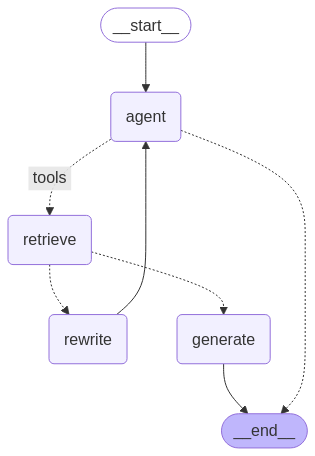

In [23]:
# Import IPython's display tools for rendering images inside the notebook
from IPython.display import Image, display

# Try rendering the compiled LangGraph as a Mermaid-based PNG diagram
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # If rendering fails (e.g., missing dependencies), skip gracefully
    pass

In [76]:
from langchain_core.messages import AIMessage, ToolMessage
from langgraph.graph import END, START, StateGraph
import pprint

# Retrieve function
def retrieve(state):
    last_message = state["messages"][-1]
    tool_call = last_message.additional_kwargs["tool_calls"][0]
    args = eval(tool_call["function"]["arguments"])  # parse JSON args
    response = retriever_tool.invoke(args)
    return {"messages": [ToolMessage(tool_call_id=tool_call["id"], content=response)]}

# Build the graph
workflow = StateGraph(AgentState)
workflow.add_node("agent", agent)
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    route_based_on_tool,
    {
        "tools": "retrieve",
        END: END,
    },
)

workflow.add_conditional_edges("retrieve", grade_documents)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile graph
graph = workflow.compile()

# Test input
inputs = {
    "messages": [
        ("user", "I want a dell XPS computer Intel® Core™ Ultra 7 165U vPro® and 1 TB SSD?"),
    ]
}

# Run and print output
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_8cjZ62RH6LDuB68KbK0tMjIk', 'function': {'arguments': '{"query":"Dell XPS Intel Core Ultra 7 165U vPro 1 TB SSD"}', 'name': 'retrieve_products'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_dbaca60df0'}, id='run-e8e9ad7b-47ae-41be-accb-56b4f2a93b02-0', tool_calls=[{'name': 'retrieve_products', 'args': {'query': 'Dell XPS Intel Core Ultra 7 165U vPro 1 TB SSD'}, 'id': 'call_8cjZ62RH6LDuB68KbK0tMjIk', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='View in 3D\xa0\xa0  ViewViewViewViewViewViewViewViewViewViewScan QR codeView Product in Augmented RealityView the system in augmented reality and see how it fits into your space.*Currentl

In [47]:
from langchain_core.messages import AIMessage, ToolMessage
from langgraph.graph import START, END, StateGraph

# --- Fixed retrieve() function that properly returns a ToolMessage tied to tool_call_id ---
def retrieve(state):
    """
    Executes the retriever tool and returns a valid ToolMessage response
    tied to the original tool_call ID from the agent.
    """
    # Extract the tool call and query
    tool_call = state["messages"][-1].additional_kwargs["tool_calls"][0]
    tool_call_id = tool_call["id"]
    import json
    query = json.loads(tool_call["function"]["arguments"])["query"]

    # Run the retriever tool
    result = retriever_tool.invoke({"query": query})

    # Return a ToolMessage to satisfy OpenAI's requirement
    return {"messages": [ToolMessage(tool_call_id=tool_call_id, content=result)]}

# --- Rebuild the graph using the updated retrieve() node ---
workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", route_based_on_tool, {
    "tools": "retrieve",
    END: END,
})
workflow.add_conditional_edges("retrieve", grade_documents)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile the updated graph
graph = workflow.compile()

In [84]:
import os
from langchain_core.messages import AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable
from langchain_openai import ChatOpenAI  #Correct import for ChatOpenAI

# Base tools — only using the retriever tool
tools = [retriever_tool]

# Initialize the language model used for scoring
llm = ChatOpenAI(model="gpt-4")  # You can change to "gpt-4o" or another variant if needed

# Prompt used to evaluate confidence level
confidence_prompt = ChatPromptTemplate.from_template("""
You are a helpful AI assistant.

The user asked:
"{question}"

You answered:
"{answer}"

How well does the answer address the question?
Respond only with a number from 0 to 100 representing your confidence.
""")

# Combine the prompt with the model
confidence_chain: Runnable = confidence_prompt | llm

# Interactive AI agent session
def run_salesperson_agent():
    print("Dell AI Salesperson Ready.")

    while True:
        # Step 1: Get user input
        user_input = input("\nWhat would you like to ask? ").strip()
        if user_input.lower() in {"no", "exit", "quit", ""}:
            print("Thank you. Have a great day.")
            break

        # Step 2: Set up initial state
        state = {
            "messages": [("user", user_input)],
            "rewrite_count": 0
        }

        final_answer = None
        gave_up = False

        # Step 3: Stream through LangGraph execution
        for output in graph.stream(state, config={"recursion_limit": 10}):
            for node_name, message in output.items():
                if node_name == "generate":
                    final_answer = message["messages"][0].content
                elif node_name == "agent" and not final_answer:
                    final_answer = message["messages"][0].content
                elif node_name == "rewrite":
                    state["rewrite_count"] += 1
                    if state["rewrite_count"] >= 3:
                        gave_up = True
                        break
            if gave_up:
                break

        # Step 4: Show recommendation and confidence
        print("\nAI Recommendation:")
        if final_answer and not gave_up:
            print(final_answer.strip())

            try:
                score_response = confidence_chain.invoke({
                    "question": user_input,
                    "answer": final_answer
                })
                confidence = score_response.content.strip()
                print(f"\nConfidence: {confidence}%")
            except Exception as e:
                print(f"\nConfidence rating failed: {str(e)}")
        else:
            print("I'm sorry, I wasn't able to confidently find a Dell product that matches your request.")
            print("Please try rephrasing your question or perform a manual search.")

        # Step 5: Continue or exit
        again = input("\nDo you have another question? (yes/no): ").strip().lower()
        if again in {"no", "exit", "quit"}:
            print("Sounds good! — If you want my 2 cents: I'd buy a Mac. Nothing beats Apple Silicon!")
            break

# Launch the session
run_salesperson_agent()

Dell AI Salesperson Ready.



What would you like to ask?  I want a dell computer for travel that has Intel® Core™ 7 150U


---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---

AI Recommendation:
Here are a couple of Dell laptops that feature Intel® Core™ i7 processors suitable for travel:

1. **Dell Inspiron 14 2-in-1 Laptop (Model: 7440)**
   - **Price:** $499.99
   - **Description:** A versatile 2-in-1 laptop that can be used as both a laptop and a tablet, making it ideal for travel.
   - **Rating:** 4.4 (427 reviews)

2. **Dell Latitude 5450 Laptop**
   - **Price:** $1,269.00
   - **Description:** A business-class laptop that offers durability and performance, suitable for professional use while traveling.
   - **Rating:** 4.4 (298 reviews)

3. **Dell Latitude 7450 Laptop or 2-in-1**
   - **Price:** $1,659.00
   - **Description:** A high-end option that provides flexibility and performance, perfect for business travelers.
   - **Rating:** 4.4 (286 reviews)

If you're looking for a more budget-friendly option, the Inspiron 14 2-in-1 is a grea


Do you have another question? (yes/no):  yes

What would you like to ask?  I want a dell computer that has Intel® Core™ Ultra 5 135U vPro® and has 512 GB SSD.


---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---

AI Recommendation:
Here are two Dell computers that meet your specifications:

1. **Dell Latitude 5450 Laptop**
   - **Price:** $1,269.00
   - **Processor:** Intel® Core™ Ultra 5 135U, vPro® (12 cores, up to 4.4 GHz Turbo)
   - **Operating System:** Windows 11 Pro
   - **Graphics:** Integrated Intel® Graphics
   - **Memory:** 16 GB DDR5
   - **Storage:** 256 GB SSD (Note: This model has a 256 GB SSD, not 512 GB)
   - **Display:** 14" Non-Touch FHD (1920x1080)
   - **Weight:** Starting at 3.09 lb (1.40 kg)
   - **Battery Life:** Up to 13 hours

2. **Dell Latitude 7450 Laptop**
   - **Price:** $1,659.00
   - **Processor:** Intel® Core™ Ultra 5 135U, vPro® (12 cores, up to 4.4 GHz Turbo)
   - **Operating System:** Windows 11 Pro
   - **Graphics:** Integrated Intel® Graphics
   - **Memory:** 16 GB LPDDR5X
   - **Storage:** 512 GB SSD
   - **Display:** 14" Non-Touch FHD+ (1920


Do you have another question? (yes/no):  yes

What would you like to ask?  I want a dell computer that has Intel® Core™ Ultra 7 165U vPro® and 1 TB SSD?"


---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---

AI Recommendation:
I'm sorry, I wasn't able to confidently find a Dell product that matches your request.
Please try rephrasing your question or perform a manual search.



Do you have another question? (yes/no):  yes

What would you like to ask?  I want a light weight XPS computer with Intel® Core™ Ultra 7 165U vPro® and 1 TB SSD


---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---

AI Recommendation:
Here are some lightweight XPS laptops that feature the Intel® Core™ Ultra 7 165U vPro® processor and a 1 TB SSD:

1. **XPS 14 Laptop (Model: 9440)**
   - **Price:** $1,499.99
   - **Processor:** Intel® Core™ Ultra 7 165U vPro®
   - **Storage:** 1 TB SSD
   - **Display:** 14.5" Non-Touch FHD+ (1920x1200)
   - **Weight:** Approximately 3.7 lbs (1.68 kg)
   - **Operating System:** Windows 11 Home
   - **Graphics:** Integrated Intel® Arc™ Graphics
   - **Memory:** 16 GB LPDDR5X
   - **Battery Life:** Up to 21 hours

2. **Latitude 7450 Laptop**
   - **Price:** $1,889.00
   - **Processor:** Intel® Core™ Ultra 7 165U vPro®
   - **Storage:** 1 TB SSD
   - **Display:** 14" Touch FHD+ (1920x1200)
   - **Weight:** Starting at 2.92 lbs (1.33 kg)
   - **Operating System:** Windows 11 Pro
   - **Graphics:** Integrated Intel® Graphics
   - **Memory:** 16 GB LPDDR5X
  


Do you have another question? (yes/no):  no


Sounds good! — If you want my 2 cents: I'd buy a Mac. Nothing beats Apple Silicon!


In [108]:
import os
import re
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable
from langchain_openai import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema.runnable import RunnableLambda

# Step 1: Load product pages
urls = [
    "https://www.dell.com/en-us/shop/dell-laptops/inspiron-14-2-in-1-laptop/spd/inspiron-14-7440-2-in-1-laptop",
    "https://www.dell.com/en-us/shop/dell-laptops/latitude-5450-laptop/spd/latitude-14-5450-laptop",
    "https://www.dell.com/en-us/shop/dell-laptops/latitude-7450-laptop/spd/latitude-14-7450-laptop",
    "https://www.dell.com/en-us/shop/dell-laptops/xps-14-laptop/spd/xps-14-9440-laptop"
]
loader = WebBaseLoader(urls)
docs = loader.load()

# Step 2: Split documents
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
chunks = splitter.split_documents(docs)

# Step 3: Embedding + Chroma
embedding = OpenAIEmbeddings()
vectorstore = Chroma.from_documents(documents=chunks, embedding=embedding)
retriever = vectorstore.as_retriever()
retriever_tool = RunnableLambda(lambda x: retriever.invoke(x["query"]))

# Step 4: LLM for confidence scoring
llm = ChatOpenAI(model="gpt-4o-mini")
confidence_prompt = ChatPromptTemplate.from_template("""
You are a helpful AI assistant evaluating a product recommendation.

The user asked:
"{question}"

The AI answered with the following Dell product info:
"{answer}"

1. Rate how well this product matches the user's request on a scale from 0 to 100.
2. Explain why this product was selected.
3. Note any important mismatches or uncertainty.

Respond in this format:

Confidence: <number>%
Explanation: <brief explanation>
""")
confidence_chain: Runnable = confidence_prompt | llm

# Step 5: Extract relevant product information
def format_response(text: str) -> str:
    text = re.sub(r'\s+', ' ', text)  # normalize whitespace

    # Skip known ad copy or marketing blocks
    if "Dell APEX" in text or "Shop Now" in text:
        return "(Filtered out promotional content.)"

    patterns = {
        "Model": r"(Inspiron\s[\w\- ]+|Latitude\s[\w\- ]+|XPS\s[\w\- ]+)",
        "Processor": r"(Intel[^.,;:\n]+Core[^.,;:\n]+)",
        "Memory": r"(\d+\s?GB\sDDR\d?)",
        "Storage": r"(\d+\s?(?:GB|TB)\sSSD)",
        "Graphics": r"(Intel.*?Graphics|NVIDIA.*?Graphics)",
        "Display": r"(\d+\".*?(FHD|OLED)[^.,;]*)",
        "OS": r"(Windows\s11\s(?:Home|Pro))",
        "Price": r"(?:Dell Price|Starting at)\s?\$[\d,]+",
        "Weight": r"([\d.]+\s?(?:lbs|lb|kg|kilograms))"
    }

    extracted = []
    for label, pattern in patterns.items():
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            value = match.group(1).strip() if match.lastindex else match.group(0).strip()
            extracted.append(f"{label}: {value}")

    return "\n".join(extracted) if extracted else "(No product specs found.)"

# Step 6: Main loop
def run_salesperson_agent():
    print("Dell AI Salesperson Ready.")

    while True:
        user_input = input("\nWhat would you like to ask? ").strip()
        if user_input.lower() in {"no", "exit", "quit", ""}:
            print("Thank you. Have a great day.")
            break

        result = retriever_tool.invoke({"query": user_input})
        final_answer = result[0].page_content if result else None

        print("\n==========================")
        print("AI Recommendation Summary")
        print("==========================")
        if final_answer:
            print("\nProduct Specs:")
            print("--------------")
            print(format_response(final_answer))

            # Get confidence + reasoning
            try:
                scored = confidence_chain.invoke({
                    "question": user_input,
                    "answer": final_answer
                })
                text = scored.content.strip()

                confidence_match = re.search(r"Confidence:\s*(\d+)", text)
                explanation_match = re.search(r"Explanation:\s*(.+)", text)

                print("\nConfidence Score:")
                print("-----------------")
                if confidence_match:
                    print(f"{confidence_match.group(1)}%")
                else:
                    print("Not available")

                print("\nWhy this product?")
                print("-----------------")
                if explanation_match:
                    print(explanation_match.group(1))
                else:
                    print(text)  # fallback

            except Exception as e:
                print(f"\n[Error]: Confidence scoring failed: {str(e)}")

        else:
            print("No relevant Dell products found.")
            print("Try rephrasing or be more specific.")

        again = input("\nWould you like to ask another question? (yes/no): ").strip().lower()
        if again in {"no", "exit", "quit"}:
            print("Sounds good! — If you want my 2 cents: I'd buy a Mac. Nothing beats Apple Silicon!")
            break

# Step 7: Run it
run_salesperson_agent()

Dell AI Salesperson Ready.



What would you like to ask?  I want a dell computer for travel that has Intel® Core™ 7 150U



AI Recommendation Summary

Product Specs:
--------------
Model: Inspiron 14 2-in-1 Laptop has been added to your cart
Processor: Intel® Core™ i5-1334U
Memory: 8 GB DDR5
Storage: 5512 GB SSD
Graphics: Intel® Core™ i5-1334U, 10 coresWindows 11 HomeIntel® UHD Graphics
Display: 14" Touch FHD+ Tech Specs Select Selected Configuration 1 Configuration 2Dell Price $1
OS: Windows 11 Home
Price: Dell Price $499

Confidence Score:
-----------------
30%

Why this product?
-----------------
The recommended product features an Intel® Core™ i7-150U processor, which is what the user explicitly requested. However, the provided product description primarily highlights an Intel® Core™ i5-1334U configuration, which does not match the user's request for an i7-150U. There are also some inconsistencies in the product details provided, as it mentions both i5 and i7 specifications, leading to confusion. Therefore, it does not adequately fulfill the user's specific request.



Would you like to ask another question? (yes/no):  yes

What would you like to ask?  I want a dell computer that has Intel® Core™ Ultra 5 135U vPro® and has 512 GB SSD.



AI Recommendation Summary

Product Specs:
--------------
Processor: Intel® Core™ Ultra 5 135U vPro® processor with Integrated Intel® GraphicsDisplay14
Graphics: Intel® Core™ Ultra 5 135U vPro® processor with Integrated Intel® Graphics
Display: 0", FHD 1920x1080
OS: Windows 11 Pro

Confidence Score:
-----------------
60%

Why this product?
-----------------
The product matches the requested Intel® Core™ Ultra™ 5 135U vPro® processor, but it does not meet the storage requirement as it only has a 256 GB SSD instead of the desired 512 GB SSD.



Would you like to ask another question? (yes/no):  I want a dell computer that has Intel® Core™ Ultra 7 165U vPro® and 1 TB SSD?"

What would you like to ask?  I want a dell computer that has Intel® Core™ Ultra 7 165U vPro® and 1 TB SSD?"



AI Recommendation Summary

Product Specs:
--------------
Processor: Intel® Core™ Ultra 5 135U vPro® processor with Integrated Intel® GraphicsDisplay14
Graphics: Intel® Core™ Ultra 5 135U vPro® processor with Integrated Intel® Graphics
Display: 0", FHD 1920x1080
OS: Windows 11 Pro

Confidence Score:
-----------------
20%

Why this product?
-----------------
The product presented is a Dell computer with an Intel® Core™ Ultra 5 135U vPro® processor, whereas the user specifically requested a model with an Intel® Core™ Ultra 7 165U vPro®. Additionally, the specified storage of 1 TB SSD is not met as the product only offers 256 GB SSD. Thus, the product does not align with the user's requirements for both processor and storage capacity.



Would you like to ask another question? (yes/no):  ywa

What would you like to ask?  I want a light weight XPS computer with Intel® Core™ Ultra 7 165U vPro® and 1 TB SSD



AI Recommendation Summary

Product Specs:
--------------
Model: XPS 14 Laptop has been added to your cart
Processor: Intel® Core™ Ultra 7 155H
Storage: 1 TB SSD
Graphics: Intel® Core™ Ultra 7 155H, 16 coresWindows 11 HomeNVIDIA® GeForce RTX™ 405032 GB LPDDR5X1 TB SSD14.5" Touch 3.2K OLED Tech Specs View Special Offers Select Selected Configuration 3 Custom Order Starting at $1,499.99 Choose from all available specs to build a custom computerCustomize now The XPS 14 Laptop has been added to your cart. CustomizationTech SpecsFeaturesReviewsSupportTech SpecsProcessorIntel® Core™ Ultra 7 155H (16 cores, up to 4.8 GHz)Operating System(Dell Technologies recommends Windows 11 Pro for business)Windows 11 Home, English, French, SpanishGraphics
Display: 5" Touch 3.2K OLED Tech Specs View Special Offers Select Selected Configuration 3 Custom Order Starting at $1
OS: Windows 11 Home
Price: Dell Price $1,999

Confidence Score:
-----------------
50%

Why this product?
-----------------
The product 


Would you like to ask another question? (yes/no):  no


Sounds good! — If you want my 2 cents: I'd buy a Mac. Nothing beats Apple Silicon!


In [5]:
import os
import re
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable
from langchain_openai import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema.runnable import RunnableLambda

# Step 1: Load Dell laptop product pages
urls = [
    "https://www.dell.com/en-us/shop/dell-laptops/inspiron-14-2-in-1-laptop/spd/inspiron-14-7440-2-in-1-laptop",
    "https://www.dell.com/en-us/shop/dell-laptops/latitude-5450-laptop/spd/latitude-14-5450-laptop",
    "https://www.dell.com/en-us/shop/dell-laptops/latitude-7450-laptop/spd/latitude-14-7450-laptop",
    "https://www.dell.com/en-us/shop/dell-laptops/xps-14-laptop/spd/xps-14-9440-laptop"
]
loader = WebBaseLoader(urls)
docs = loader.load()

# Step 2: Split into chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
chunks = splitter.split_documents(docs)

# Step 3: Embed documents and store in Chroma
embedding = OpenAIEmbeddings()
vectorstore = Chroma.from_documents(documents=chunks, embedding=embedding)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

# Step 4: Setup LLM for selection
llm = ChatOpenAI(model="gpt-4o")
selection_prompt = ChatPromptTemplate.from_template("""
You are a helpful product expert. A user asked: "{query}"

Here are 3 Dell product descriptions:
{docs}

Which one best fits the user's request? Justify your choice in 1-2 sentences, then list the key specifications in bullet form.
""")
selector_chain: Runnable = selection_prompt | llm

# Step 5: Run the chatbot
def run_salesperson_agent():
    print("Dell AI Salesperson Ready.")

    while True:
        user_input = input("\nWhat would you like to ask? ").strip()
        if user_input.lower() in {"no", "exit", "quit", ""}:
            print("Thank you. Have a great day.")
            break

        try:
            # FIX: send raw query string, not a dictionary
            results = retriever.invoke(user_input)
            top_docs = "\n\n".join([doc.page_content for doc in results])

            answer = selector_chain.invoke({
                "query": user_input,
                "docs": top_docs
            })

            print("\n==========================")
            print("AI Recommendation Summary")
            print("==========================")
            print(answer.content.strip())

        except Exception as e:
            print("\n[Error]: Recommendation failed:", str(e))

        again = input("\nWould you like to ask another question? (yes/no): ").strip().lower()
        if again in {"no", "exit", "quit"}:
            print("Sounds good! — If you want my 2 cents: I'd buy a Mac. Nothing beats Apple Silicon!")
            break

# Run it
run_salesperson_agent()

Dell AI Salesperson Ready.



What would you like to ask?  exit


Thank you. Have a great day.


In [13]:
import os
import time
from tqdm import tqdm
from langchain_community.document_loaders import WebBaseLoader
from langchain_chroma import Chroma  # Updated import
from langchain.embeddings import OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable
from langchain_openai import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema.runnable import RunnableLambda

# Constants
VECTORSTORE_DIR = "chroma_dell_laptops"

# Step 1: Load Dell laptop product pages
urls = [
    "https://www.dell.com/en-us/shop/dell-laptops/inspiron-14-2-in-1-laptop/spd/inspiron-14-7440-2-in-1-laptop",
    "https://www.dell.com/en-us/shop/dell-laptops/latitude-5450-laptop/spd/latitude-14-5450-laptop",
    "https://www.dell.com/en-us/shop/dell-laptops/latitude-7450-laptop/spd/latitude-14-7450-laptop",
    "https://www.dell.com/en-us/shop/dell-laptops/xps-14-laptop/spd/xps-14-9440-laptop"
]

loader = WebBaseLoader(urls)
docs = loader.load()

# Step 2: Split into small, overlapping chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=100)
chunks = splitter.split_documents(docs)

# Step 3: Create or load Chroma vector store
embedding = OpenAIEmbeddings()

if os.path.exists(VECTORSTORE_DIR):
    vectorstore = Chroma(persist_directory=VECTORSTORE_DIR, embedding_function=embedding)
else:
    vectorstore = Chroma.from_documents(
        documents=chunks,
        embedding=embedding,
        persist_directory=VECTORSTORE_DIR
    )

retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

# Step 4: Setup LLM and prompt
llm = ChatOpenAI(model="gpt-4o")
selection_prompt = ChatPromptTemplate.from_template("""
You are a helpful product expert. A user asked: "{query}"

Here are some Dell product descriptions:
{docs}

Which one best fits the user's request? Justify your choice in 1-2 sentences, then list the key specifications in bullet form.
""")
selector_chain: Runnable = selection_prompt | llm

# Step 5: Run the chatbot
def run_salesperson_agent():
    print("Dell AI Salesperson Ready.")

    while True:
        user_input = input("\nWhat would you like to ask? ").strip()
        if user_input.lower() in {"no", "exit", "quit", ""}:
            print("Thank you. Have a great day.")
            break

        try:
            results = retriever.invoke(user_input)
            top_docs = "\n\n".join([doc.page_content for doc in results])

            print("\nGenerating your recommendation", end="")
            for _ in tqdm(range(20), bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}", ncols=40):
                time.sleep(0.05)

            answer = selector_chain.invoke({
                "query": user_input,
                "docs": top_docs
            })

            print("\n\n==========================")
            print("AI Recommendation Summary")
            print("==========================")
            print(answer.content.strip())

        except Exception as e:
            print("\n[Error]: Recommendation failed:", str(e))

# Launch the agent
run_salesperson_agent()

Dell AI Salesperson Ready.



What would you like to ask?  I want a Dell computer for travel that has Intel® Core™ 7 150U.



Generating your recommendation

100%|████████████████████████████| 20/20




AI Recommendation Summary
The user is specifically looking for a Dell computer with the Intel® Core™ 7 150U processor. Based on the given product descriptions, the first listing is the best fit as it includes the Intel® Core™ 7 150U processor.

Key Specifications:
- Price: $1,049.99
- Processor: Intel® Core™ 7 150U, 10 cores
- Operating System: Windows 11 Pro
- Graphics: Intel® Graphics
- Memory: 16 GB DDR5
- Storage: 512 GB SSD
- Display: 14" Touch FHD+



What would you like to ask?  I want a Dell computer that has Intel® Core™ Ultra 5 135U vPro® and has 512 GB SSD.



Generating your recommendation

100%|████████████████████████████| 20/20




AI Recommendation Summary
The Dell computer priced at $1,399.00 best fits the user's request as it has the Intel® Core™ Ultra 5 135U vPro® processor and 512 GB SSD, which specifically matches the user's requirements.

Key Specifications:
- Intel® Core™ Ultra 5 135U, vPro®
- Windows 11 Pro
- Intel® Graphics
- 16 GB DDR5
- 512 GB SSD
- 14" Non-Touch FHD Display



What would you like to ask?  I want a Dell computer that has Intel® Core™ Ultra 7 165U vPro® and 1 TB SSD?



Generating your recommendation

100%|████████████████████████████| 20/20




AI Recommendation Summary
None of the listed Dell computers fully meet the user's request for a model with an Intel® Core™ Ultra 7 165U vPro® processor and a 1 TB SSD. However, the third configuration with an Intel® Core™ 7 150U processor is the closest match based on processor naming, though it does not meet the "Ultra" or vPro® specifications, nor does it have 1 TB SSD storage.

Key Specifications (for the closest match):
- Processor: Intel® Core™ 7 150U, 10 cores
- Operating System: Windows 11 Pro
- Graphics: Intel® Graphics
- Memory: 16 GB DDR5
- Storage: 512 GB SSD
- Display: 14" Touch FHD+



What would you like to ask?  “I want a light weight XPS computer with Intel® Core™ Ultra 7 165U vPro® and 1 TB SSD.”



Generating your recommendation

100%|████████████████████████████| 20/20




AI Recommendation Summary
None of the listed product descriptions exactly match the user's request for a Dell XPS computer with an Intel® Core™ Ultra 7 165U vPro® processor and a 1 TB SSD. However, if looking for the nearest available option, consider a future model or customization possibility, as no available models meet the criteria with the specified processor and SSD capacity.

Key specifications of the closest available models include:
- Processor: Intel® Core™ Ultra 7 155H
- Graphics: Intel® Arc™ Graphics
- Memory: 16 GB LPDDR5X
- SSD: 512 GB (below the requested 1 TB)
- Operating System: Windows 11 Home



What would you like to ask?  exit


Thank you. Have a great day.
